In [1]:
import os
import torch
import json
import random
from src.Utils import plot_data, create_mask, plot_mask, compare_folders
from src.CustomDataset import CustomDataset
from models import UNet
from torch.utils.data import DataLoader
from torchvision import transforms
from loss import dice_loss

%load_ext autoreload
%autoreload 2

In [2]:
val_dir = "data/valid"
with open ("data/valid/_annotations.coco.json", "r") as f:
    annotations = json.load(f)
all_images = [os.path.join(val_dir, f) for f in os.listdir(val_dir) if f.endswith(".jpg")]


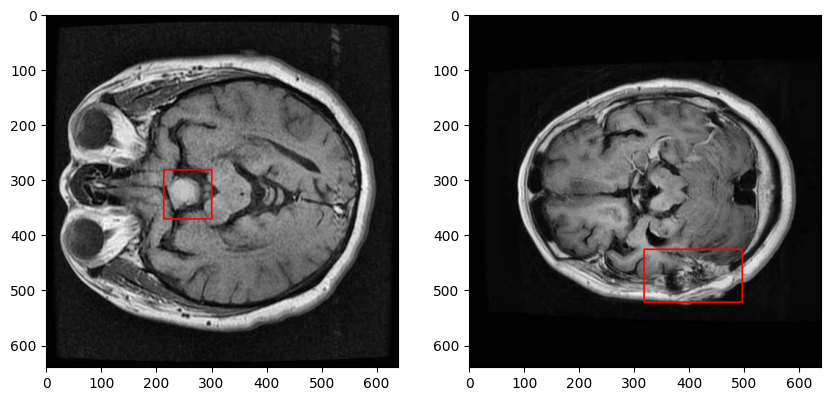

In [3]:
random_image_files = random.sample(all_images,2)
plot_data(random_image_files, annotations)


In [4]:
for part in (os.listdir("data")):
    original_image_dir = f"data/{part}"
    json_file = f"data/{part}/_annotations.coco.json"
    mask_dir = f"data1/{part}/masks"
    img_dir = f"data1/{part}/images"
    create_mask(json_file,mask_dir,img_dir,original_image_dir)

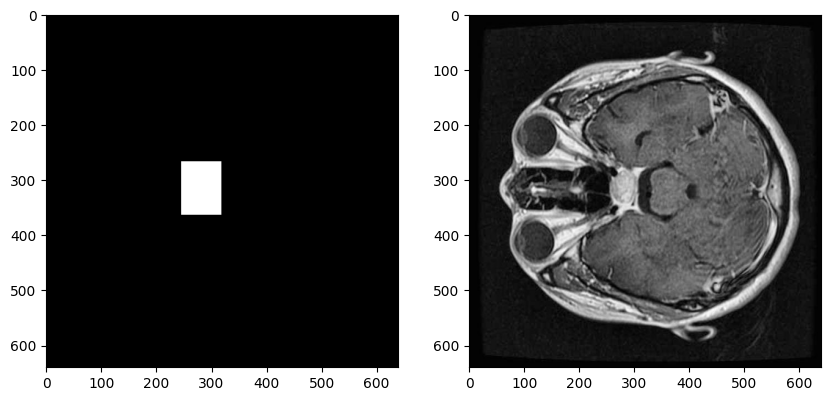

In [5]:
plot_mask("data1/valid/masks", "data1/valid/images")

In [6]:
compare_folders("data1/valid/masks", "data1/valid/images")
compare_folders("data1/test/masks", "data1/test/images")
compare_folders("data1/train/masks", "data1/train/images")

Deleted file: data1/train/images\2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg


In [7]:
train_path = "data1/train"
test_path = "data1/test"
val_path = "data1/valid"

image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

train_dataset = CustomDataset(train_path, transform=image_transform)
valid_dataset = CustomDataset(val_path, transform=image_transform)
test_dataset = CustomDataset(test_path, transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet.UNet().to(device)
criterion = dice_loss.DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epoches = 20

checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
def train(model,optimizer,loss_fn,loader,device):
    epoch_loss =0.0
    model.train()
    
    for x,y in tqdm(loader):
        x = x.to(device,dtype = torch.float32)
        y = y.to(device, dtype = torch.float32)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        epoch_loss +=loss.item()
    
    return epoch_loss/len(loader)

In [11]:
def valid(model,loader,loss_fn,device):
    epoch_loss = 0.0
    model.eval()
    
    for x,y in loader:
        x = x.to(device,dtype = torch.float32)
        y = y.to(device, dtype = torch.float32)
        pred = model(x)
        loss = loss_fn(pred,y)
        epoch_loss +=loss.item()
    return epoch_loss/len(loader)



Epoch 10/10, Train Loss: 0.4517
Cross Loss: 0.4634


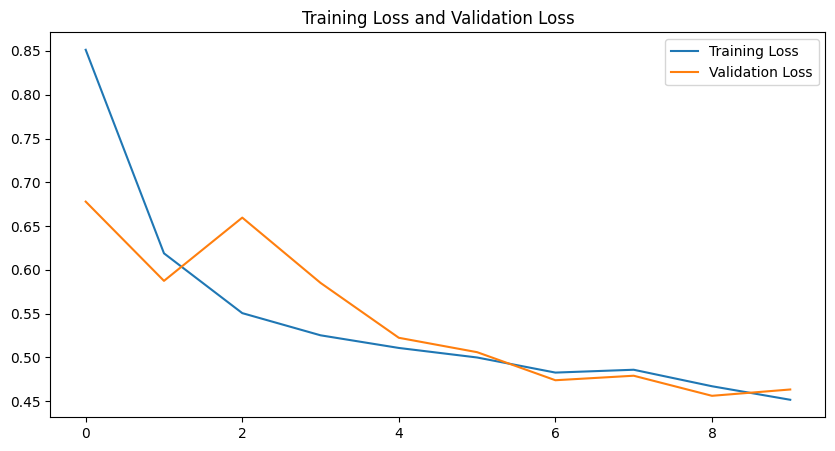

In [13]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

best_val_loss = float('inf')
train_losses = []
cross_losses = []

for epoch in range(epoches):
    train_loss = train(model, optimizer, criterion, train_loader, device)
    val_loss = valid(model, valid_loader, criterion, device)
    train_losses.append(train_loss)
    cross_losses.append(val_loss)
    
    clear_output(wait=True)
    print(f'Epoch {epoch+1}/{epoches}, Train Loss: {train_loss:.4f}')
    print(f'Cross Loss: {val_loss:.4f}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(cross_losses, label='Validation Loss')
    plt.title('Training Loss and Validation Loss')
    plt.legend()
    plt.show(block=False)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_path = os.path.join(checkpoint_dir, f'best_model.pt')
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Best model checkpoint saved at {checkpoint_path}')